<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/Bayesian/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian

# TODO:

1. Use oregon original data to find the ranges for labels (no phophet)
2. compute rolling average' - Done (phophet)
3. Using rolling average find daily_growth_values - done (phophet)
4. use the first step to label the county.(phophet)
5. That labeling will become 'c'
6. Bayesian inference

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [43]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import scipy.sparse as sparse
import pymc3 as pm
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [3]:
oregon_estimates = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/oregon_total.csv',low_memory=False)
oregon_estimates.head()

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FIPS,FIPS_lower,FIPS_upper,Imported.COVID.cases,Imported.COVID.cases_lower,Imported.COVID.cases_upper,Miles.person,Miles.person_lower,Miles.person_upper,Testing.capacity,Testing.capacity_lower,Testing.capacity_upper,Tests.done.1000.people,Tests.done.1000.people_lower,Tests.done.1000.people_upper,Unemployment.claims.1000.people,Unemployment.claims.1000.people_lower,Unemployment.claims.1000.people_upper,Unemployment.rate,Unemployment.rate_lower,Unemployment.rate_upper,Work.trips.person,Work.trips.person_lower,Work.trips.person_upper,X..Male,X..Male_lower,X..Male_upper,X..out.of.county.trips,X..out.of.county.trips_lower,X..out.of.county.trips_upper,X..out.of.state.trips,X..out.of.state.trips_lower,X..out.of.state.trips_upper,...,X..staying.home_lower,X..staying.home_upper,X..working.from.home,X..working.from.home_lower,X..working.from.home_upper,X.days..decreasing.COVID.cases,X.days..decreasing.COVID.cases_lower,X.days..decreasing.COVID.cases_upper,X.days..decreasing.ILI.cases,X.days..decreasing.ILI.cases_lower,X.days..decreasing.ILI.cases_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline_lower,grocery_and_pharmacy_percent_change_from_baseline_upper,m50_index,m50_index_lower,m50_index_upper,parks_percent_change_from_baseline,parks_percent_change_from_baseline_lower,parks_percent_change_from_baseline_upper,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lower,retail_and_recreation_percent_change_from_baseline_upper,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline_lower,transit_stations_percent_change_from_baseline_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,County Name
0,0,2020-03-01,0.022545,-35.934197,16.396559,0.022545,0.022545,37.274823,37.274823,37.274823,-22.520971,-22.520971,-22.520971,-0.175145,-0.175145,-0.175145,-0.073633,-0.073633,-0.073633,-8.393329,-8.393329,-8.393329,-3.621713,-3.621713,-3.621713,12.479047,12.479047,12.479047,-3.195004,-3.195004,-3.195004,0.014009,0.014009,0.014009,1.826094,1.826094,1.826094,0.186635,0.186635,0.186635,...,0.000826,0.000826,-15.347575,-15.347575,-15.347575,-4.621245,-4.621245,-4.621245,-1.611269,-1.611269,-1.611269,-9.248902,-9.248902,-9.248902,-4.913130,-4.913130,-4.913130,-1.684826,-1.684826,-1.684826,0.092022,0.092022,0.092022,0.0,0.0,0.0,4.424264,4.424264,4.424264,0.035065,0.035065,0.035065,-4.335772,-4.335772,-4.335772,0.0,0.0,0.0,-9.226357,Jefferson County
1,1,2020-03-02,-0.040928,-35.777943,18.576615,-0.040928,-0.040928,37.274823,37.274823,37.274823,-22.520971,-22.520971,-22.520971,-0.175145,-0.175145,-0.175145,-0.073633,-0.073633,-0.073633,-8.393329,-8.393329,-8.393329,-3.621713,-3.621713,-3.621713,12.479047,12.479047,12.479047,-3.195004,-3.195004,-3.195004,0.014009,0.014009,0.014009,1.826094,1.826094,1.826094,0.186635,0.186635,0.186635,...,0.000826,0.000826,-15.347575,-15.347575,-15.347575,-4.621245,-4.621245,-4.621245,-1.611269,-1.611269,-1.611269,-7.308187,-7.308187,-7.308187,-5.015334,-5.015334,-5.015334,-1.684826,-1.684826,-1.684826,-0.010182,-0.010182,-0.010182,0.0,0.0,0.0,4.424264,4.424264,4.424264,0.035065,0.035065,0.035065,-2.292852,-2.292852,-2.292852,0.0,0.0,0.0,-7.349115,Jefferson County
2,2,2020-03-03,-0.104401,-29.908882,22.517049,-0.104401,-0.104401,37.274823,37.274823,37.274823,-22.520971,-22.520971,-22.520971,-0.175145,-0.175145,-0.175145,-0.073633,-0.073633,-0.073633,-8.393329,-8.393329,-8.393329,-3.621713,-3.621713,-3.621713,12.479047,12.479047,12.479047,-3.195004,-3.195004,-3.195004,0.014009,0.014009,0.014009,1.826094,1.826094,1.826094,0.186635,0.186635,0.186635,...,0.000826,0.000826,-15.347575,-15.347575,-15.347575,-4.6212

In [4]:
Superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/AllStates_Superset_dataset_Feb21.csv',low_memory=False)
Superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-03,Montana,30001,0,Beaverhead County,0.0,1.139,86,9.0,7.0,0.0,0.0,-2.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,17,20,3.33,20.4,6.6,34.1,0.68,2.65,0,9404,13.2,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.00,39,46.600000,0.0,0.00,0.00,0,0,0.00,0,0.7,3.5,6.6,0.3,0.00,0.0,NaN
1,2020-03-04,Montana,30001,0,Beaverhead County,0.0,1.480,113,14.0,7.0,0.0,0.0,3.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,13,16,3.44,21.3,8.4,36.1,0.71,2.73,0,9404,16.7,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.00,40,46.600000,0.0,0.00,0.00,0,0,0.00,0,0.7,3.5,6.6,0.3,0.00,0.0,NaN
2,2020-04-21,Montana,30001,0,Beaverhead County,0.0,1.107,84,0.0,0.0,0.0,0.0,-22.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,22,13,2.90,16.3,6.9,25.2,0.52,2.39,0,9404,2.1,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.38,11,47.156862,3.9,10.58,1.49,4,2,0.08,49,6.2,11.2,24.1,0.0,14.65,0.0,NaN
3,2020-04-22,Montana,30001,0,Beaverhead County,0.0,1.286,98,0.0,0.0,0.0,0.0,-24.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,13,16,3.18,21.3,7.7,40.9,0.62,2.56,0,9404,9.4,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.38,12,47.025863,3.8,10.90,1.19,3,2,0.08,49,6.2,11.2,24.1,0.0,17.01,0.0,NaN
4,2020-04-23,Montana,30001,0,Beaverhead County,0.0,1.730,132,0.0,0.0,0.0,0.0,-30.0,0.0,0.654314,Montana,MT,30001,Beaverhead County,30,17,18,3.33,19.8,10.7,32.4,0.54,2.79,0,9404,19.2,0.02,29,44809,0.1,4.5,50.55,1,177,3.26,0.32,0.113,0.0,0.37,13,46.894867,3.7,11.18,0.89,2,3,0.08,49,6.2,11.2,24.1,0.0,16.97,0.0,NaN


## Test for 1 County : Washington County

In [5]:
oregon_estimates_WC = oregon_estimates[oregon_estimates['County Name'] == "Washington County"]
oregon_estimates_WC.tail(7)

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FIPS,FIPS_lower,FIPS_upper,Imported.COVID.cases,Imported.COVID.cases_lower,Imported.COVID.cases_upper,Miles.person,Miles.person_lower,Miles.person_upper,Testing.capacity,Testing.capacity_lower,Testing.capacity_upper,Tests.done.1000.people,Tests.done.1000.people_lower,Tests.done.1000.people_upper,Unemployment.claims.1000.people,Unemployment.claims.1000.people_lower,Unemployment.claims.1000.people_upper,Unemployment.rate,Unemployment.rate_lower,Unemployment.rate_upper,Work.trips.person,Work.trips.person_lower,Work.trips.person_upper,X..Male,X..Male_lower,X..Male_upper,X..out.of.county.trips,X..out.of.county.trips_lower,X..out.of.county.trips_upper,X..out.of.state.trips,X..out.of.state.trips_lower,X..out.of.state.trips_upper,...,X..staying.home_lower,X..staying.home_upper,X..working.from.home,X..working.from.home_lower,X..working.from.home_upper,X.days..decreasing.COVID.cases,X.days..decreasing.COVID.cases_lower,X.days..decreasing.COVID.cases_upper,X.days..decreasing.ILI.cases,X.days..decreasing.ILI.cases_lower,X.days..decreasing.ILI.cases_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline_lower,grocery_and_pharmacy_percent_change_from_baseline_upper,m50_index,m50_index_lower,m50_index_upper,parks_percent_change_from_baseline,parks_percent_change_from_baseline_lower,parks_percent_change_from_baseline_upper,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lower,retail_and_recreation_percent_change_from_baseline_upper,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline_lower,transit_stations_percent_change_from_baseline_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,County Name
3002,344,2021-02-19,31.124012,22.554299,43.679036,23.828167,39.162056,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-0.240451,-0.240451,-15.646082,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,1.338049,1.338049,1.338049,-3.018117,-3.018117,-3.018117,-10.744525,-10.744525,-10.744525,-0.006911,-0.006911,-0.006911,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,4.356166,4.356166,4.356166,0.0,0.0,0.0,32.462061,Washington County
3003,345,2021-02-20,31.420181,25.392286,46.441464,24.027276,39.626928,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-0.240451,-0.240451,-15.646082,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,4.025795,4.025795,4.025795,-3.019666,-3.019666,-3.019666,-10.744525,-10.744525,-10.744525,-0.008460,-0.008460,-0.008460,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,7.045461,7.045461,7.045461,0.0,0.0,0.0,35.445976,Washington County
3004,346,2021-02-21,31.716349,24.251684,45.809474,24.143916,40.200079,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-0.240451,-0.240451,-15.646082,-15.646082,-15.646082,0.

In [6]:
OR_Superset_data_WC = Superset_data[(Superset_data['County Name'] == "Washington County") & (Superset_data['Province_State'] == "Oregon")] 
OR_Superset_data_WC.tail()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
1687256,2020-12-28,Oregon,41067,295,Washington County,10.0,7.454,102,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,34,28,3.13,31.3,3.1,36.1,0.43,2.69,295,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.3658,8.96,19,58.111926,4.3,620.04,14.56,70,3435,19.47,35,3.7,9.6,30.1,1.71,1.73,49.356277,49.356277
1687257,2020-12-28,Oregon,41067,295,Washington County,10.0,4.767,81,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,34,28,3.13,31.3,3.1,36.1,0.43,2.69,295,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.3658,8.96,19,58.111926,4.3,620.04,14.56,70,3435,19.47,35,3.7,9.6,30.1,1.71,1.73,49.356277,49.356277
1687258,2020-12-28,Oregon,41067,295,Washington County,10.0,3.128,59,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,34,28,3.13,31.3,3.1,36.1,0.43,2.69,295,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.3658,8.96,19,58.111926,4.3,620.04,14.56,70,3435,19.47,35,3.7,9.6,30.1,1.71,1.73,49.356277,49.356277
1687259,2020-12-28,Oregon,41067,295,Washington County,10.0,7.089,56,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,34,28,3.13,31.3,3.1,36.1,0.43,2.69,295,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.3658,8.96,19,58.111926,4.3,620.04,14.56,70,3435,19.47,35,3.7,9.6,30.1,1.71,1.73,49.356277,49.356277
1687260,2020-12-28,Oregon,41067,295,Washington County,10.0,6.240,48,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,Oregon,OR,41067,Washington County,41,34,28,3.13,31.3,3.1,36.1,0.43,2.69,295,597695,-9.6,6.13,18,78010,1.9,16.5,49.42,354,132,2.2,0.2,0.024,0.3658,8.96,19,58.111926,4.3,620.04,14.56,70,3435,19.47,35,3.7,9.6,30.1,1.71,1.73,49.356277,49.356277


In [7]:
OR_Superset_data_WC['Date'] = OR_Superset_data_WC['Date'].astype('datetime64[ns]')
OR_Superset_data_WC = OR_Superset_data_WC.groupby("County Name").resample('D', on='Date').mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
OR_Superset_data_WC.shape

(303, 56)

In [9]:
OR_Superset_data_WC.tail()

,County Name,Date,FIPS,New cases,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,CTFIPS,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
298,Washington County,2020-12-24,41067.0,78.0,10.0,5.969536,63.857143,-19.0,34.0,-4.0,-65.0,-67.0,20.0,310.164459,41067.0,41.0,35.0,27.0,3.29,28.9,2.9,34.4,0.23,3.05,78.0,597695.0,2.5,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.1935,9.29,15.0,57.590477,4.2,605.50,13.01,66.0,3355.0,19.70,35.0,3.7,9.6,30.1,1.71,1.71,13.050134,13.731323
299,Washington County,2020-12-25,41067.0,0.0,10.0,1.488464,14.571429,-86.0,-67.0,0.0,-81.0,-87.0,29.0,310.164459,41067.0,41.0,64.0,44.0,1.89,33.8,5.8,33.4,0.24,1.66,0.0,597695.0,-44.2,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.1082,9.02,16.0,57.699507,4.2,605.50,13.01,66.0,2263.0,19.47,35.0,3.7,9.6,30.1,1.71,1.73,0.000000,1.398229
300,Washington County,2020-12-26,41067.0,85.0,10.0,5.446071,53.285714,-39.0,-22.0,-14.0,-60.0,-26.0,11.0,310.164459,41067.0,41.0,44.0,33.0,2.94,29.7,3.6,37.5,0.24,2.70,85.0,597695.0,-9.3,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.0909,9.38,17.0,57.822113,4.3,605.50,13.01,67.0,3207.0,19.47,35.0,3.7,9.6,30.1,1.71,1.73,14.221300,12.697589
301,Washington County,2020-12-27,41067.0,276.0,10.0,3.953000,38.321429,-33.0,-23.0,-5.0,-53.0,-18.0,8.0,310.164459,41067.0,41.0,46.0,34.0,2.83,29.8,3.8,39.6,0.21,2.62,276.0,597695.0,-12.0,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.2013,9.16,18.0,57.959428,4.3,605.50,13.01,69.0,3010.0,19.47,35.0,3.7,9.6,30.1,1.71,1.73,46.177398,42.753531
302,Washington County,2020-12-28,41067.0,295.0,10.0,6.795393,67.750000,-20.0,-12.0,12.0,-59.0,-52.0,16.0,310.164459,41067.0,41.0,34.0,28.0,3.13,31.3,3.1,36.1,0.43,2.69,295.0,597695.0,-9.6,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.3658,8.96,19.0,58.111926,4.3,620.04,14.56,70.0,3435.0,19.47,35.0,3.7,9.6,30.1,1.71,1.73,49.356277,49.015683


### Find Ranges for the labels

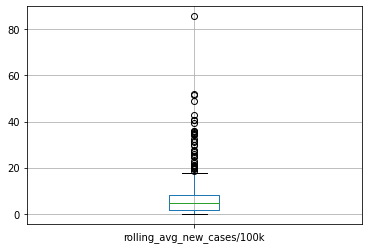

In [35]:
boxplot = OR_Superset_data_WC.boxplot(column=['rolling_avg_new_cases/100k'],rot=0, fontsize=10)

In [11]:
OR_Superset_data_WC['rolling_avg_new_cases/100k'].describe()

count    292.000000
mean       8.127840
std       10.877029
min       -0.059753
25%        1.749944
50%        4.621923
75%        8.202643
max       85.596691
Name: rolling_avg_new_cases/100k, dtype: float64

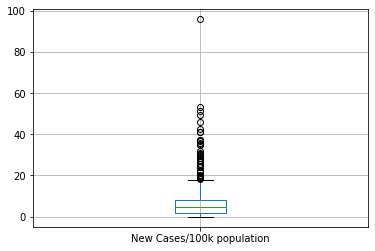

In [26]:
boxplot = OR_Superset_data_WC.boxplot(column=['New Cases/100k population'],rot=0, fontsize=10)

In [27]:
OR_Superset_data_WC['New Cases/100k population'].describe()

count    292.000000
mean       8.137999
std       11.244321
min       -0.167309
25%        1.673094
50%        4.684664
75%        8.239989
max       95.868294
Name: New Cases/100k population, dtype: float64

### Compute Daily Average

In [34]:
# CA_counties = df['County Name'].unique()
# for county in CA_counties:
#   county_data = df[df['County Name'] == county]
#   #print(county_data.iloc[:,15])
#   county_data['daily_growth_range'] = county_data.iloc[:,avg_col_idx].diff().fillna(0)
#   df_growthrange = df_growthrange.append(county_data)
# df_growthrange.head()
avg_col_idx = OR_Superset_data_WC.columns.get_loc("rolling_avg_new_cases/100k")
print(avg_col_idx)
OR_Superset_data_WC['daily_growth_range'] = OR_Superset_data_WC.iloc[:,avg_col_idx].diff().fillna(0)

55


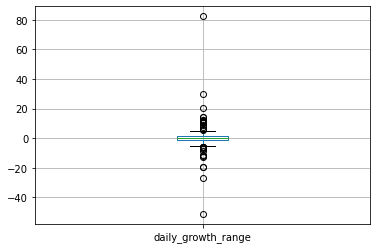

In [37]:
boxplot = OR_Superset_data_WC.boxplot(column=['daily_growth_range'],rot=0, fontsize=10)

In [36]:
OR_Superset_data_WC['daily_growth_range'].describe()

count    303.000000
mean       0.193754
std        7.178467
min      -51.274360
25%       -1.347438
50%        0.000000
75%        1.263784
max       82.387936
Name: daily_growth_range, dtype: float64

#### Summary on values

* minimal - < (0.5*std) - std 
* No Change - std
* widespread - > (0.5*std) + std





### Labelling Oregon Data

min :  -51.27435995186274 max:  82.38793555719404
points  (-6.972857020053614, 7.36036580480761)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

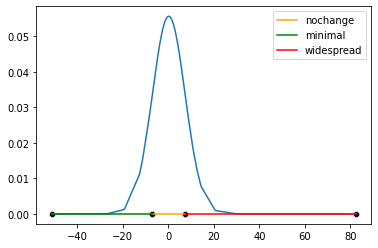

In [48]:
mean = OR_Superset_data_WC['daily_growth_range'].mean()
x_values = OR_Superset_data_WC['daily_growth_range'].values
standard_deviation = np.std(x_values)
x_values = np.sort(x_values)
y_values = scipy.stats.norm(mean, standard_deviation)
plt.plot(x_values, y_values.pdf(x_values))
print('min : ',x_values.min(), 'max: ',x_values.max())
median = np.median(x_values)
st_dev = np.std(x_values)
mini = x_values.min()
maxi = x_values.max()
range1 = mini, mean-st_dev
#range2 = mean-2*st_dev, mean-st_dev
points =  mean-st_dev, mean+st_dev
#range3 = mean+st_dev,  mean+2*st_dev
range4 =  mean+st_dev,maxi
print('points ',points)
sns.lineplot(points, [0,0], color = 'orange', label = "nochange")
sns.scatterplot(points, [0,0], color = 'black')
sns.scatterplot(range1, [0,0], color = 'black')
#sns.scatterplot(range2, [0,0], color = 'blue', label = "range2")
#sns.scatterplot(range3, [0,0], color = 'green', label = "range3")
sns.scatterplot(range4, [0,0], color = 'black')
sns.lineplot(range1, [0,0], color = 'green', label = "minimal")
#sns.lineplot(range2, [0,0], color = 'blue', label = "std_dev")
#sns.lineplot(range3, [0,0], color = 'green', label = "std_dev")
sns.lineplot(range4, [0,0], color = 'red', label = "widespread")

In [50]:
print(range1)
print(points)
print(range4)

(-51.27435995186274, -6.972857020053614)
(-6.972857020053614, 7.36036580480761)
(7.36036580480761, 82.38793555719404)


###  Step 1: Label Summary: From the daily growth values from washington county as follows
* Minimum: (-51.27435995186274, -6.972857020053614)
* No Change: (-6.972857020053614, 7.36036580480761)
* Maximum: (7.36036580480761, 82.38793555719404)

### Compute Rolling Average

In [67]:
col_idx  = oregon_estimates_WC.columns.get_loc("yhat")
col_idx

82

In [68]:
df = pd.DataFrame(columns=['Unnamed: 0', 'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'FIPS', 'FIPS_lower', 'FIPS_upper',
       'Imported.COVID.cases', 'Imported.COVID.cases_lower',
       'Imported.COVID.cases_upper', 'Miles.person', 'Miles.person_lower',
       'Miles.person_upper', 'Testing.capacity', 'Testing.capacity_lower',
       'Testing.capacity_upper', 'Tests.done.1000.people',
       'Tests.done.1000.people_lower', 'Tests.done.1000.people_upper',
       'Unemployment.claims.1000.people',
       'Unemployment.claims.1000.people_lower',
       'Unemployment.claims.1000.people_upper', 'Unemployment.rate',
       'Unemployment.rate_lower', 'Unemployment.rate_upper',
       'Work.trips.person', 'Work.trips.person_lower',
       'Work.trips.person_upper', 'X..Male', 'X..Male_lower', 'X..Male_upper',
       'X..out.of.county.trips', 'X..out.of.county.trips_lower',
       'X..out.of.county.trips_upper', 'X..out.of.state.trips',
       'X..out.of.state.trips_lower', 'X..out.of.state.trips_upper',
       'X..people.older.than.60', 'X..people.older.than.60_lower',
       'X..people.older.than.60_upper', 'X..staying.home',
       'X..staying.home_lower', 'X..staying.home_upper',
       'X..working.from.home', 'X..working.from.home_lower',
       'X..working.from.home_upper', 'X.days..decreasing.COVID.cases',
       'X.days..decreasing.COVID.cases_lower',
       'X.days..decreasing.COVID.cases_upper', 'X.days..decreasing.ILI.cases',
       'X.days..decreasing.ILI.cases_lower',
       'X.days..decreasing.ILI.cases_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline_lower',
       'grocery_and_pharmacy_percent_change_from_baseline_upper', 'm50_index',
       'm50_index_lower', 'm50_index_upper',
       'parks_percent_change_from_baseline',
       'parks_percent_change_from_baseline_lower',
       'parks_percent_change_from_baseline_upper',
       'retail_and_recreation_percent_change_from_baseline',
       'retail_and_recreation_percent_change_from_baseline_lower',
       'retail_and_recreation_percent_change_from_baseline_upper',
       'transit_stations_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline_lower',
       'transit_stations_percent_change_from_baseline_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat',
       'County Name', 'growth', 'growth_label_estimate','rolling_avg_new_cases/100k'])

In [69]:
OR_counties = oregon_estimates_WC['County Name'].unique()

for county in OR_counties:
  county_data = oregon_estimates_WC[oregon_estimates_WC['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases/100k'] = county_data.iloc[:,col_idx].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FIPS,FIPS_lower,FIPS_upper,Imported.COVID.cases,Imported.COVID.cases_lower,Imported.COVID.cases_upper,Miles.person,Miles.person_lower,Miles.person_upper,Testing.capacity,Testing.capacity_lower,Testing.capacity_upper,Tests.done.1000.people,Tests.done.1000.people_lower,Tests.done.1000.people_upper,Unemployment.claims.1000.people,Unemployment.claims.1000.people_lower,Unemployment.claims.1000.people_upper,Unemployment.rate,Unemployment.rate_lower,Unemployment.rate_upper,Work.trips.person,Work.trips.person_lower,Work.trips.person_upper,X..Male,X..Male_lower,X..Male_upper,X..out.of.county.trips,X..out.of.county.trips_lower,X..out.of.county.trips_upper,X..out.of.state.trips,X..out.of.state.trips_lower,X..out.of.state.trips_upper,...,X..working.from.home_upper,X.days..decreasing.COVID.cases,X.days..decreasing.COVID.cases_lower,X.days..decreasing.COVID.cases_upper,X.days..decreasing.ILI.cases,X.days..decreasing.ILI.cases_lower,X.days..decreasing.ILI.cases_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline_lower,grocery_and_pharmacy_percent_change_from_baseline_upper,m50_index,m50_index_lower,m50_index_upper,parks_percent_change_from_baseline,parks_percent_change_from_baseline_lower,parks_percent_change_from_baseline_upper,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lower,retail_and_recreation_percent_change_from_baseline_upper,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline_lower,transit_stations_percent_change_from_baseline_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,County Name,growth,growth_label_estimate,rolling_avg_new_cases/100k,daily_growth_range
2658,0,2020-03-01,0.021290,-11.260310,2.703756,0.021290,0.021290,11.75593,11.75593,11.75593,-9.714754,-9.714754,-9.714754,-2.449953,-2.449953,-2.449953,0.085802,0.085802,0.085802,7.026021,7.026021,7.026021,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,-3.141552,-3.141552,-3.141552,0.004709,0.004709,0.004709,0.769948,0.769948,0.769948,-0.202502,-0.202502,-0.202502,...,-16.240973,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,-4.297645,-4.297645,-4.297645,-10.361349,-10.361349,-10.361349,-4.116872,-4.116872,-4.116872,-0.002266,-0.002266,-0.002266,-0.123472,-0.123472,-0.123472,15.073559,15.073559,15.073559,-13.128327,-13.128327,-13.128327,6.063704,6.063704,6.063704,0.0,0.0,0.0,-4.276354,Washington County,0,nochange,NaN,0.0
2659,1,2020-03-02,-0.186732,-23.062746,-9.824196,-0.186732,-0.186732,11.75593,11.75593,11.75593,-9.714754,-9.714754,-9.714754,-2.449953,-2.449953,-2.449953,0.085802,0.085802,0.085802,7.026021,7.026021,7.026021,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,-3.141552,-3.141552,-3.141552,0.004709,0.004709,0.004709,0.769948,0.769948,0.769948,-0.202502,-0.202502,-0.202502,...,-16.240973,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,-16.172242,-16.172242,-16.172242,-10.362123,-10.362123,-10.362123,-4.116872,-4.116872,-4.116872,-0.003040,-0.003040,-0.003040,-0.123472,-0.123472,-0.123472,15.073559,15.073559,15.073559,-13.128327,-13.128327,-13.128327,-5.810119,-5.810119,-5.810119,0.0,0.0,0.0,-16.358975,Washington County,0,nochange,NaN,0.0
2660,2,2020-03-03,-0.394755,-22.498474,-8.341978,-0.394755,-0.394755,11.75593,11.75593,11.75593,-9.714754,-9.714754,-9.714754,-2.449953,-2.449953,-2.449953,0.085802,0.085802,0.085802,7.026021,7.026021,7.026021,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,-3.141552,-3.141552,-3.141552,0.004709,0.004709,0.004709,0.769948,0.769948,0.769948,-0.202502,-0.202502,-0.202502,...,-16.240973,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,-15.081437,-15.081437,-15.081437,-1

In [70]:
df.columns

Index(['Unnamed: 0', 'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'FIPS', 'FIPS_lower', 'FIPS_upper',
       'Imported.COVID.cases', 'Imported.COVID.cases_lower',
       'Imported.COVID.cases_upper', 'Miles.person', 'Miles.person_lower',
       'Miles.person_upper', 'Testing.capacity', 'Testing.capacity_lower',
       'Testing.capacity_upper', 'Tests.done.1000.people',
       'Tests.done.1000.people_lower', 'Tests.done.1000.people_upper',
       'Unemployment.claims.1000.people',
       'Unemployment.claims.1000.people_lower',
       'Unemployment.claims.1000.people_upper', 'Unemployment.rate',
       'Unemployment.rate_lower', 'Unemployment.rate_upper',
       'Work.trips.person', 'Work.trips.person_lower',
       'Work.trips.person_upper', 'X..Male', 'X..Male_lower', 'X..Male_upper',
       'X..out.of.county.trips', 'X..out.of.county.trips_lower',
       'X..out.of.county.trips_upper', 'X..out.of.state.trips',
       'X..out.of.state.trips_lower', '

In [72]:
df = df.fillna(0)
df.tail()
oregon_estimates_WC = df

### Step 3: Computing the daily growth for prophet estimates

In [73]:
avg_col_idx = oregon_estimates_WC.columns.get_loc("rolling_avg_new_cases/100k")
print(avg_col_idx)
oregon_estimates_WC['daily_growth_range'] = oregon_estimates_WC.iloc[:,avg_col_idx].diff().fillna(0)

86


### Step 4: Labelling Prophet Data using Step 1 values

In [74]:
oregon_estimates_WC['growth_label_estimate'] = "Its great"
for index, row in (oregon_estimates_WC.iterrows()):
      i = row['daily_growth_range']
      #print(i)
      if i > range4[1] :
        label = 'widespread'
        date = row['ds']
        df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['ds'] == date)
        oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
        continue
      elif i >= range4[0] and i <= range4[1] :
        label = 'widespread'
        date = row['ds']
        df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['ds'] == date)
        oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
        continue
      # elif i <= range3[1] and i > range3[0]:
      #   label = 'substantial'
      #   date = row['Date']
      #   df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['Date'] == date)
      #   oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
      #   continue
      elif i <= points[1] and i >= points[0]:
        label = 'nochange'
        date = row['ds']
        df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['ds'] == date)
        oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
        continue
      # elif i >= range2[0] and i < range2[1]:
      #   label = 'moderate'
      #   date = row['Date']
      #   df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['Date'] == date)
      #   oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
      #   continue
      elif i <= range1[1] and i > range1[0] :
        label = 'minimal'
        date = row['ds']
        df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['ds'] == date)
        oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
        continue
      elif i < range1[1] :
        label = 'minimal'
        date = row['ds']
        df_index = (oregon_estimates_WC['County Name'] == county) & (oregon_estimates_WC['ds'] == date)
        oregon_estimates_WC.loc[df_index,'growth_label_estimate'] = label
        continue
    #break

### Spread Labeling

In [ ]:
# prior_new_cases = 0
# oregon_estimates_WC['growth'] = 0
# oregon_estimates_WC['growth_label_estimate'] = "Its great"
# standard_deviation = oregon_estimates_WC['rolling_avg_new_cases/100k'].std()
# for index, row in oregon_estimates_WC.iterrows():
#   # Change over time for cases
#   print(row['rolling_avg_new_cases/100k'] - prior_new_cases)
#   oregon_estimates_WC['growth'][index] = row['rolling_avg_new_cases/100k'] - prior_new_cases
#   prior_new_cases = row['rolling_avg_new_cases/100k']

#   i = row['growth']
#   if i > (1.5 * standard_deviation) :
#     label = 'widespread'
#     c_value = sparse.coo_matrix(([0,0,1]), shape=(1,3))
#   elif (i <= (1.5 * standard_deviation)) and (i >= (0.5 * standard_deviation)):
#     label = 'No Change'
#     c_value = sparse.coo_matrix(([0,1,0]), shape=(1,3))
#   elif i < (0.5 * standard_deviation) :
#     label = 'minimal'
#     c_value = sparse.coo_matrix(([1,0,0]), shape=(1,3))

#   oregon_estimates_WC['growth_label_estimate'][index] = label

In [17]:
oregon_estimates_WC.tail()

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FIPS,FIPS_lower,FIPS_upper,Imported.COVID.cases,Imported.COVID.cases_lower,Imported.COVID.cases_upper,Miles.person,Miles.person_lower,Miles.person_upper,Testing.capacity,Testing.capacity_lower,Testing.capacity_upper,Tests.done.1000.people,Tests.done.1000.people_lower,Tests.done.1000.people_upper,Unemployment.claims.1000.people,Unemployment.claims.1000.people_lower,Unemployment.claims.1000.people_upper,Unemployment.rate,Unemployment.rate_lower,Unemployment.rate_upper,Work.trips.person,Work.trips.person_lower,Work.trips.person_upper,X..Male,X..Male_lower,X..Male_upper,X..out.of.county.trips,X..out.of.county.trips_lower,X..out.of.county.trips_upper,X..out.of.state.trips,X..out.of.state.trips_lower,X..out.of.state.trips_upper,...,X..working.from.home_lower,X..working.from.home_upper,X.days..decreasing.COVID.cases,X.days..decreasing.COVID.cases_lower,X.days..decreasing.COVID.cases_upper,X.days..decreasing.ILI.cases,X.days..decreasing.ILI.cases_lower,X.days..decreasing.ILI.cases_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline_lower,grocery_and_pharmacy_percent_change_from_baseline_upper,m50_index,m50_index_lower,m50_index_upper,parks_percent_change_from_baseline,parks_percent_change_from_baseline_lower,parks_percent_change_from_baseline_upper,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lower,retail_and_recreation_percent_change_from_baseline_upper,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline_lower,transit_stations_percent_change_from_baseline_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,County Name,growth,growth_label_estimate,rolling_avg_new_cases/100k
3004,346,2021-02-21,31.716349,24.251684,45.809474,24.143916,40.200079,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,3.049201,3.049201,3.049201,-3.014504,-3.014504,-3.014504,-10.744525,-10.744525,-10.744525,-0.003298,-0.003298,-0.003298,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,6.063704,6.063704,6.063704,0.0,0.0,0.0,34.765550,Washington County,0,minimal,27.808435
3005,347,2021-02-22,32.012518,12.025028,34.423515,24.199929,40.730120,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,-8.824881,-8.824881,-8.824881,-3.014762,-3.014762,-3.014762,-10.744525,-10.744525,-10.744525,-0.003556,-0.003556,-0.003556,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,-5.810119,-5.810119,-5.810119,0.0,0.0,0.0,23.187637,Washington County,0,minimal,28.105120
3006,348,2021-02-23,32.308687,13.340518,35.573895,24.266093,41.162555,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,-7.7

In [18]:
oregon_estimates_WC_tail = oregon_estimates_WC.tail(7)
oregon_estimates_WC_tail

,Unnamed: 0,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,FIPS,FIPS_lower,FIPS_upper,Imported.COVID.cases,Imported.COVID.cases_lower,Imported.COVID.cases_upper,Miles.person,Miles.person_lower,Miles.person_upper,Testing.capacity,Testing.capacity_lower,Testing.capacity_upper,Tests.done.1000.people,Tests.done.1000.people_lower,Tests.done.1000.people_upper,Unemployment.claims.1000.people,Unemployment.claims.1000.people_lower,Unemployment.claims.1000.people_upper,Unemployment.rate,Unemployment.rate_lower,Unemployment.rate_upper,Work.trips.person,Work.trips.person_lower,Work.trips.person_upper,X..Male,X..Male_lower,X..Male_upper,X..out.of.county.trips,X..out.of.county.trips_lower,X..out.of.county.trips_upper,X..out.of.state.trips,X..out.of.state.trips_lower,X..out.of.state.trips_upper,...,X..working.from.home_lower,X..working.from.home_upper,X.days..decreasing.COVID.cases,X.days..decreasing.COVID.cases_lower,X.days..decreasing.COVID.cases_upper,X.days..decreasing.ILI.cases,X.days..decreasing.ILI.cases_lower,X.days..decreasing.ILI.cases_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline_lower,grocery_and_pharmacy_percent_change_from_baseline_upper,m50_index,m50_index_lower,m50_index_upper,parks_percent_change_from_baseline,parks_percent_change_from_baseline_lower,parks_percent_change_from_baseline_upper,retail_and_recreation_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lower,retail_and_recreation_percent_change_from_baseline_upper,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline_lower,transit_stations_percent_change_from_baseline_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,County Name,growth,growth_label_estimate,rolling_avg_new_cases/100k
3002,344,2021-02-19,31.124012,22.554299,43.679036,23.828167,39.162056,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,1.338049,1.338049,1.338049,-3.018117,-3.018117,-3.018117,-10.744525,-10.744525,-10.744525,-0.006911,-0.006911,-0.006911,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,4.356166,4.356166,4.356166,0.0,0.0,0.0,32.462061,Washington County,0,minimal,27.211894
3003,345,2021-02-20,31.420181,25.392286,46.441464,24.027276,39.626928,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,4.025795,4.025795,4.025795,-3.019666,-3.019666,-3.019666,-10.744525,-10.744525,-10.744525,-0.008460,-0.008460,-0.008460,-1.012969,-1.012969,-1.012969,10.782937,10.782937,10.782937,-6.87583,-6.87583,-6.87583,7.045461,7.045461,7.045461,0.0,0.0,0.0,35.445976,Washington County,0,minimal,27.508948
3004,346,2021-02-21,31.716349,24.251684,45.809474,24.143916,40.200079,11.75593,11.75593,11.75593,-9.657896,-9.657896,-9.657896,-0.548662,-0.548662,-0.548662,-0.063323,-0.063323,-0.063323,7.02087,7.02087,7.02087,0.060649,0.060649,0.060649,2.465281,2.465281,2.465281,8.600041,8.600041,8.600041,0.004709,0.004709,0.004709,-0.262869,-0.262869,-0.262869,-0.274316,-0.274316,-0.274316,...,-15.646082,-15.646082,0.601973,0.601973,0.601973,1.023476,1.023476,1.023476,3.049201,3

In [19]:
c = []
for index, row in  oregon_estimates_WC_tail.iterrows():
  if(row['growth_label_estimate'] == 'minimal'):
    c_value = [1,0,0]
  elif (row['growth_label_estimate'] == 'No Change'):
    c_value = [0,1,0]
  else:
    c_value = [0,0,1]

  c.append(c_value)

c = np.array(c)

In [20]:
print(c)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


### Setup Bayesian Model

In [21]:
alphas = np.array([1, 1, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=1, p=parameters, shape=3, observed=c)
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]
100%|██████████| 1500/1500 [00:01<00:00, 1048.03it/s]


In [22]:
labels = ['minimal', 'No Change', 'widespread']

In [23]:
trace_df = pd.DataFrame(trace['parameters'], columns = labels)
print(trace_df.shape)
trace_df.head()

(2000, 3)


,minimal,No Change,widespread
0,0.689807,0.175510,0.134683
1,0.900690,0.084099,0.015212
2,0.866566,0.091553,0.041881
3,0.866566,0.091553,0.041881
4,0.663028,0.112312,0.224661


In [24]:
def display_probs(d):
    for key, value in d.items():
        print(f'Labels: {key:8} Prevalence: {100*value:.2f}%.')

In [25]:
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(labels, pvals)))

Labels: minimal  Prevalence: 80.12%.
Labels: No Change Prevalence: 10.07%.
Labels: widespread Prevalence: 9.81%.
